<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

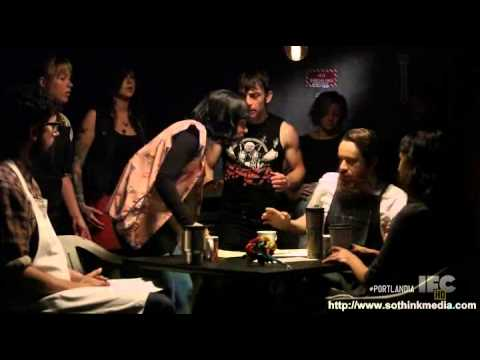

In [215]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [216]:
%pwd

'/home/adriann/Lambda/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [10]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [11]:
# import re to grab just alphabetical words in reviews
import re
# iterate through the range of the length of the df
for i in range(len(shops)):
    # slice the review so that it removes the date
    shops['full_review_text'].loc[i] = shops['full_review_text'].loc[i][11:]
    # strip all leading and trailing spaces
    shops['full_review_text'].loc[i] = shops['full_review_text'].loc[i].strip(" ")
    # remove all numerical values in the review
    shops['full_review_text'].loc[i] = re.sub('[^a-zA-Z ]', '', shops['full_review_text'].loc[i])
    # remove ' star rating ' in the star_rating
    shops['star_rating'].loc[i] = shops['star_rating'].loc[i].replace(' star rating ','')
    # strip all leading and trailing spaces
    shops['star_rating'].loc[i] = shops['star_rating'].loc[i].strip(" ")

In [13]:
# Check to see if everything looks correct
shops['full_review_text'][0]

' checkin Love love loved the atmosphere Every corner of the coffee shop had its own style and there were swings I ordered the matcha latte and it was muy fantastico Ordering and getting my drink were pretty streamlined I ordered on an iPad which included all beverage selections that ranged from coffee to wine desired level of sweetness and a checkout system I got my latte within minutes  I was hoping for a typical heart or feather on my latte but found myself listing out all the possibilities of what the art may be Any ideas'

In [220]:
# Check to see if everything looks correct
# Keeping it as a string because it doesn't change anything if numeric
shops['star_rating'][0]

'5.0'

In [221]:
import spacy
from spacy.tokenizer import Tokenizer

# load spacy
nlp = spacy.load("en_core_web_lg")

# Create the tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [222]:
# Add more stop words to the list to remove redundant words
stop_words = nlp.Defaults.stop_words.union(['coffee', ' ', 'im', 'place', 'austin', 'come'])

In [223]:
# create empty list
tokens = []
# for loop that iterates through each review through the tokenizer pipeline
for doc in tokenizer.pipe(shops['full_review_text']):
    # empty list to hold the list of tokens
    doc_tokens = []
    # iterate through each token in the review
    for token in doc:
        # checks to see if a token is in the stop_words list
        if token.text.lower() not in stop_words:
            # appends the tokens into the doc_tokens list
            doc_tokens.append(token.text.lower())
    # appends the list of tokens into the tokens list        
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

In [224]:
def get_lemmas(text):
    lemmas = []
    
    doc = nlp(text)
    
    for token in doc:
        if ((token.text.lower() not in stop_words) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
            
    return lemmas

shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

In [225]:
from collections import Counter

word_counts = Counter()

shops['tokens'].apply(lambda x: word_counts.update(x))

word_counts.most_common(10)

[('good', 3958),
 ('great', 3875),
 ('like', 3088),
 ('checkin', 1966),
 ('love', 1926),
 ('time', 1884),
 ('food', 1835),
 ('nice', 1733),
 ('shop', 1680),
 ('friendly', 1655)]

In [226]:
shops['star_rating'].value_counts()

5.0    3780
4.0    2360
3.0     738
2.0     460
1.0     278
Name: star_rating, dtype: int64

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [227]:
def count(docs):
    word_counts = Counter()
    appears_in = Counter()
    
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))
        
    temp = zip(word_counts.keys(), word_counts.values())
    
    wc = pd.DataFrame(temp, columns = ['word', 'count'])
    
    total = wc['count'].sum()
    
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    
    return wc

In [228]:
bad = shops[(shops['star_rating'] == '1.0') | (shops['star_rating'] == '2.0') | (shops['star_rating'] == '3.0')]

good = shops[(shops['star_rating'] == '4.0') | (shops['star_rating'] == '5.0')]

In [229]:
wc1 = count(bad['tokens'])

wc2 = count(good['tokens'])

wc3 = count(bad['lemmas'])

wc4 = count(good['lemmas'])

In [230]:
wc1 = wc1.sort_values(by='count', ascending=False)

wc2 = wc2.sort_values(by='count', ascending=False)

wc3 = wc3.sort_values(by='count', ascending=False)

wc4 = wc4.sort_values(by='count', ascending=False)

In [231]:
wc1.head()

,word,count,pct_total
29,like,876,0.011612
2,good,874,0.011586
52,food,483,0.006403
184,time,478,0.006336
62,great,464,0.006151


In [232]:
wc3.head()

,word,count,pct_total
132,not,1697,0.022410
2,good,987,0.013034
29,like,935,0.012347
46,order,760,0.010036
191,time,607,0.008016


In [233]:
wc2.head()

,word,count,pct_total
127,great,3411,0.012821
193,good,3084,0.011592
200,like,2212,0.008314
1,love,1718,0.006457
0,checkin,1605,0.006033


In [234]:
wc4.head()

,word,count,pct_total
189,good,4279,0.016047
63,not,3462,0.012983
123,great,3370,0.012638
0,checkin,2526,0.009473
196,like,2411,0.009042


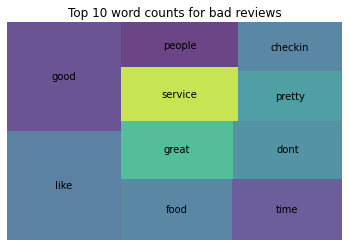

In [235]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc1.head(10)

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8)
plt.axis('off')
plt.title('Top 10 word counts for bad reviews')
plt.show()

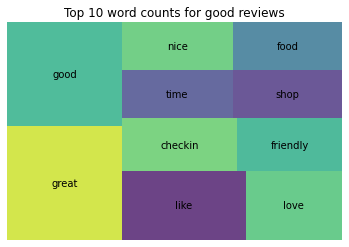

In [236]:
wc_top20 = wc2.head(10)

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8)
plt.axis('off')
plt.title('Top 10 word counts for good reviews')
plt.show()

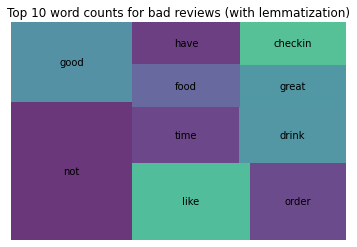

In [237]:
wc_top20 = wc3.head(10)

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8)
plt.axis('off')
plt.title('Top 10 word counts for bad reviews (with lemmatization)')
plt.show()

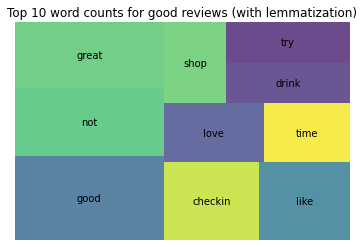

In [238]:
wc_top20 = wc4.head(10)

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8)
plt.axis('off')
plt.title('Top 10 word counts for good reviews (with lemmatization)')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

